In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the directory containing subfolders with npz files

base_dir = '/home/debian/jz/Mari_Models/TrackModels'
# Initialize lists to store data for nuclei and membrane channels
nuclei_loss_data = []
nuclei_accuracy_data = []
nuclei_train_loss_data = []
nuclei_train_accuracy_data = []
nuclei_folders = []

membrane_loss_data = []
membrane_accuracy_data = []
membrane_train_loss_data = []
membrane_train_accuracy_data = []
membrane_folders = []

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)

    if os.path.isdir(folder_path) and 'attention' in folder:
        # Find the npz file in the directory
        for file in os.listdir(folder_path):
            if file.endswith('.npz'):
                file_path = os.path.join(folder_path, file)
                try:
                    data = np.load(file_path, allow_pickle=True)
                    if 'validation_loss' in data:
                        steps = data['validation_loss'].item().get('steps', [])
                        values = data['validation_loss'].item().get('values', [])

                        train_steps = data['train_loss_epoch'].item().get('steps', [])
                        train_values = data['train_loss_epoch'].item().get('values', [])



                        if len(steps) == len(values):
                            if 'nuclei' in folder:
                                nuclei_loss_data.append((steps, values))
                                nuclei_train_loss_data.append((train_steps, train_values))
                                nuclei_folders.append(folder)

                            elif 'membrane' in folder:
                                membrane_loss_data.append((steps, values))
                                membrane_train_loss_data.append((train_steps, train_values))
                                membrane_folders.append(folder)
                    if 'validation_accuracy' in data:
                        acc_steps = data['validation_accuracy'].item().get('steps', [])
                        acc_values = data['validation_accuracy'].item().get('values', [])

                        train_acc_steps = data['train_accuracy_epoch'].item().get('steps', [])
                        train_acc_values = data['train_accuracy_epoch'].item().get('values', [])

                        if len(acc_steps) == len(acc_values):
                            if 'nuclei' in folder:
                                nuclei_accuracy_data.append((acc_steps, acc_values))
                                nuclei_train_accuracy_data.append((train_acc_steps, train_acc_values))
                            elif 'membrane' in folder:
                                membrane_accuracy_data.append((acc_steps, acc_values))
                                membrane_train_accuracy_data.append((train_acc_steps, train_acc_values))
                except Exception as e:
                    print(f'Skipping {folder} {e}') 

# Number of nuclei and membrane models
num_nuclei_models = len(nuclei_folders)
num_membrane_models = len(membrane_folders)

# Define subplots for nuclei and membrane
cols = 2
nuclei_rows = (num_nuclei_models + 1) // cols
membrane_rows = (num_membrane_models + 1) // cols

fig_nuclei, axes_nuclei = plt.subplots(nuclei_rows, cols, figsize=(20, 25))
axes_nuclei = axes_nuclei.flatten()

fig_membrane, axes_membrane = plt.subplots(membrane_rows, cols, figsize=(20, 25))
axes_membrane = axes_membrane.flatten()

# Plot for nuclei models
for i, ax in enumerate(axes_nuclei[:num_nuclei_models]):
    folder = nuclei_folders[i]

    # Construct the title as per your request
    posttitle = "_".join(folder.split("_")[-5:])
    title = "_".join(folder.split("_")[:2])
    title += '_' + posttitle
    
    # Plot validation loss
    steps, values = nuclei_loss_data[i]
    train_steps, train_values = nuclei_train_loss_data[i]
    ax.plot(range(len(values)), values, label='Val Loss', linestyle='--', color='b')
    ax.plot(range(len(train_values)), train_values, label='Train Loss', linestyle='--', color='r')
    # Plot validation accuracy if available
    if i < len(nuclei_accuracy_data):
        acc_steps, acc_values = nuclei_accuracy_data[i]
        train_acc_steps, train_acc_values = nuclei_train_accuracy_data[i]
        ax.plot(range(len(acc_values)), acc_values, label='Val Accuracy', color='g')
        ax.plot(range(len(train_acc_values)), train_acc_values, label='Train Accuracy', color='r')
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Metric Value', fontsize=12)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True)

# Plot for membrane models
for i, ax in enumerate(axes_membrane[:num_membrane_models]):
    folder = membrane_folders[i]

    # Construct the title as per your request
    posttitle = "_".join(folder.split("_")[-4:])
    title = "_".join(folder.split("_")[:2])
    title += '_' + posttitle

    # Plot validation loss
    steps, values = membrane_loss_data[i]
    train_steps, train_values = membrane_train_loss_data[i]
    ax.plot(range(len(values)), values, label='Val Loss', linestyle='--', color='b')
    ax.plot(range(len(train_values)), train_values, label='Train Loss', linestyle='--', color='r')

    # Plot validation accuracy if available
    if i < len(membrane_accuracy_data):
        acc_steps, acc_values = membrane_accuracy_data[i]
        train_acc_steps, train_acc_values = membrane_train_accuracy_data[i]
        ax.plot(range(len(acc_values)), acc_values, label=' Val Accuracy', color='g')
        ax.plot(range(len(train_acc_values)), train_acc_values, label=' Train Accuracy', color='r')
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Metric Value', fontsize=12)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True)

# Adjust layout to avoid overlap and add more vertical spacing
plt.tight_layout()
fig_nuclei.subplots_adjust(hspace=0.5)  # Adjust vertical spacing for nuclei plots
fig_membrane.subplots_adjust(hspace=0.5)  # Adjust vertical spacing for membrane plots


plt.show()


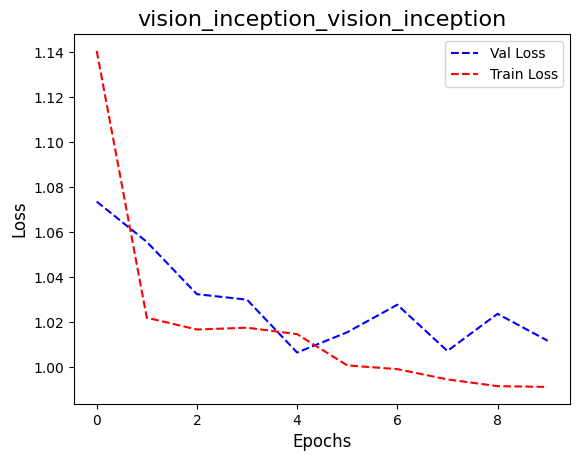

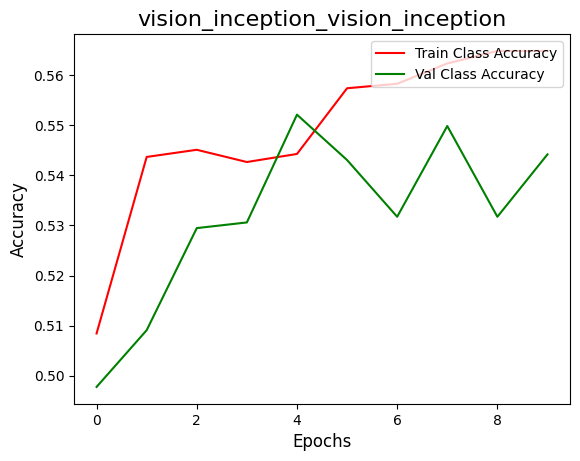

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the directory containing subfolders with npz files

base_dir = '/home/debian/jz/Mari_Models/TrackModels'
vision_loss_data = []
vision_accuracy_data = []
vision_train_loss_data = []
vision_train_accuracy_data = []
vision_folders = []



for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)

    if os.path.isdir(folder_path) and 'vision' in folder:
        # Find the npz file in the directory
        for file in os.listdir(folder_path):
            if file.endswith('.npz'):
                file_path = os.path.join(folder_path, file)
                try:
                    data = np.load(file_path, allow_pickle=True)
                    if 'validation_loss' in data:
                        steps = data['validation_loss'].item().get('steps', [])
                        values = data['validation_loss'].item().get('values', [])

                        train_steps = data['train_loss_epoch'].item().get('steps', [])
                        train_values = data['train_loss_epoch'].item().get('values', [])



                        if len(steps) == len(values):
                           
                                vision_loss_data.append((steps, values))
                                vision_train_loss_data.append((train_steps, train_values))
                                vision_folders.append(folder)

                            
                    if 'validation_class_accuracy' in data:
                        acc_steps = data['validation_class_accuracy'].item().get('steps', [])
                        acc_values = data['validation_class_accuracy'].item().get('values', [])

                        train_acc_steps = data['train_class_accuracy_epoch'].item().get('steps', [])
                        train_acc_values = data['train_class_accuracy_epoch'].item().get('values', [])
                        
                        vision_accuracy_data.append((acc_steps, acc_values))
                        vision_train_accuracy_data.append((train_acc_steps, train_acc_values))
                            
                except Exception as e:
                    print(f'Skipping {folder} {e}') 


for i, ax in enumerate(vision_folders):
    folder = vision_folders[i]

    # Construct the title as per your request
    posttitle = "_".join(folder.split("_")[-5:])
    title = "_".join(folder.split("_")[:2])
    title += '_' + posttitle
    
    # Plot validation loss
    steps, values = vision_loss_data[i]
    train_steps, train_values = vision_train_loss_data[i]
    plt.plot(range(len(values)), values, label='Val Loss', linestyle='--', color='b')
    plt.plot(range(len(train_values)), train_values, label='Train Loss', linestyle='--', color='r')
    
    
    plt.title(f'{title}', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.show()
    acc_steps, acc_values = vision_accuracy_data[i]
    train_acc_steps, train_acc_values = vision_train_accuracy_data[i]
    
    plt.plot(range(len(train_acc_values)), train_acc_values, label='Train Class Accuracy', color='r')
    plt.plot(range(len(acc_values)), acc_values, label='Val Class Accuracy', color='g')
    plt.title(f'{title}', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.show()
